In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import  check_integrity, download_and_extract_archive
import torch.optim as optim
import seaborn as sns
from PIL import Image
import os
import os.path
import numpy as np
import pickle
from typing import Any, Callable, Optional, Tuple

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Small data and deep learning
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (2 points):__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

We sample the same number of examples for all the targets in order to have a balanced dataset target wise.

In [5]:
class CIFAR10(VisionDataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    
    This class takes an argument N which is the number of training samples. We set the default value to 100.
    """
    
    base_folder = 'cifar-10-batches-py'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]
    meta = {
        'filename': 'batches.meta',
        'key': 'label_names',
        'md5': '5ff9c542aee3614f3951f8cda6e48888',
    }

    def __init__(
            self,
            root: str,
            N : int = 100,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
        
    ) -> None:

        super(CIFAR10, self).__init__(root, transform=transform,
                                      target_transform=target_transform)

        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data: Any = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                if 'labels' in entry:
                    self.targets.extend(entry['labels'])
                else:
                    self.targets.extend(entry['fine_labels'])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC
        if self.train:
            print("ORIGINAL SHAPE OF DATASET")
            print('IMG',self.data.shape)
            print('TARGET',len(self.targets))
            
            
            unique_class = set(self.targets)
            n_unique_class = len(unique_class)
            n_per_class = int(N / n_unique_class)
            balanced_data = {key:[] for key in unique_class}
            
             # Sampling the same number of examples for all the targets in order to have balanced data target wise
             # we assume there are more than n_unique_class number of samples per class.
            sum_class = 0
            i = 0
            
            while i < len(self.targets) and sum_class < N:
                label = self.targets[i]
                if len(balanced_data[label]) < n_per_class:
                    balanced_data[label].append(self.data[i])
                    sum_class += 1
                i += 1
                
#             n_unique_class = len(unique_class)
#             n_per_class = int(N / n_unique_class)
#             balanced_data = []
#             balanced_targets = []
#             for targ in unique_class:
#                 i = 0
#                 while i < n_per_class and i < len(self.targets):
#                     if self.targets[i] == targ:
#                         balanced_data.append(self.data[i])
#                         balanced_targets.append(self.targets[i])
            all_data = []
            all_targets = []
            for k in sorted(balanced_data.keys()):
                all_data.extend(balanced_data[k])
                all_targets.extend([k]*len(balanced_data[k]))
                
            self.data = np.array(all_data)
            self.targets = np.array(all_targets)
            
            
            
#             for k in balanced_data:
#                 balanced_data[k] = (torch.cat([balanced_data[k]]))
#             self.data = torch.cat([])
#             self.targets = self.targets[0:N]

            print("NEW SHAPE OF DATASET")
            print('IMG',self.data.shape)
            print('TARGET',len(self.targets))
            sns.countplot(self.targets).set_title('COUNT PLOT OF TRAIN TARGETS');

        self._load_meta()


    def _load_meta(self) -> None:
        path = os.path.join(self.root, self.base_folder, self.meta['filename'])
        if not check_integrity(path, self.meta['md5']):
            raise RuntimeError('Dataset metadata file not found or corrupted.' +
                               ' You can use download=True to download it')
        with open(path, 'rb') as infile:
            data = pickle.load(infile, encoding='latin1')
            self.classes = data[self.meta['key']]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self) -> int:
        return len(self.data)

    def _check_integrity(self) -> bool:
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self) -> None:
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        download_and_extract_archive(self.url, self.root, filename=self.filename, md5=self.tgz_md5)

    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")


Extracting ./data/cifar-10-python.tar.gz to ./data
ORIGINAL SHAPE OF DATASET
IMG (50000, 32, 32, 3)
TARGET 50000
NEW SHAPE OF DATASET
IMG (100, 32, 32, 3)
TARGET 100


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Files already downloaded and verified


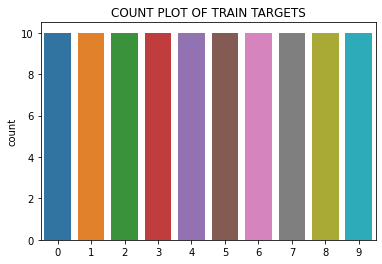

In [6]:
transform = torchvision.transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = CIFAR10(root='./data', train=True,download=True, transform=transform,N=100)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

image max coordinate: tensor(1.)
image min coordinate: tensor(-1.)


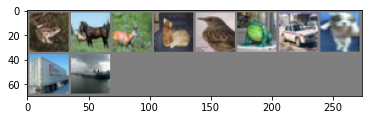

 frog horse  deer   cat


In [7]:
def imshow(img):
    """
    Function to visualise samples from dataloaders
    
    """
    print("image max coordinate:", img.max())
    print("image min coordinate:", img.min())
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

**Response 2:** <br>
The evaluation of the training procedure is difficult because we have few samples per class. Thus it is probable that we will overfit our training data before getting a correct knowledge of the characteristic elements of the dataset. Moreover, some classes are under-represented making it difficult for the model to differentiate them efficiently.

A few solutions are:

- Data augmentation: apply some geometric transformation to our sample to artificially create new samples from which the model could learn.
- Transfer learning: Import a model already trained on another dataset and add some layers ( or retrain last layers ) to transfer the classification capabilities to our use-case
- Use a semi-supervised method.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points):__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

__Model definition__

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):

    """
    Residual block
    Implementation of a residual skip block 
    
    """
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    """
    Implementation of a Resnet model constructed from residual blocks
    """
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    """
    Return an instance of type Resnet18 of the class Resnet
    
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [9]:
def train(epoch,model,trainloader,criterion,optimizer):

    """

    Train a model for 1 epoch and print the training loss and accuracy

    """
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    batch_counter =0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        batch_counter+=1
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print("LOSS",train_loss/batch_counter)
    print("ACCURACY",correct/total)

In [10]:
def test(model,testloader,criterion):
    """
    
    Test a model print the global test loss and test accuracy

    """
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    batch_counter =0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            batch_counter+=1
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print("LOSS",test_loss/batch_counter)
    print("ACCURACY",correct/total)          

In [11]:
# Parameter initialisation

ResNet18_ = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet18_.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

Training the model

In [ ]:
for epoch in range(0, 30):
    train(epoch, ResNet18_, trainloader, criterion, optimizer)


Epoch: 0
LOSS 0.39875998548232017
ACCURACY 0.87

Epoch: 1
LOSS 0.5406923204660415
ACCURACY 0.88

Epoch: 2
LOSS 0.5734869536012411
ACCURACY 0.83

Epoch: 3
LOSS 0.28608294650912286
ACCURACY 0.9

Epoch: 4
LOSS 0.256199499592185
ACCURACY 0.91

Epoch: 5
LOSS 0.21236431440338494
ACCURACY 0.94

Epoch: 6
LOSS 0.10881123756989837
ACCURACY 0.97

Epoch: 7
LOSS 0.11563994982279838
ACCURACY 0.96

Epoch: 8
LOSS 0.1214716739486903
ACCURACY 0.95

Epoch: 9
LOSS 0.05636571077629924
ACCURACY 0.99

Epoch: 10
LOSS 0.0888939443975687
ACCURACY 0.96

Epoch: 11
LOSS 0.07666194252669811
ACCURACY 0.98

Epoch: 12
LOSS 0.09086674597347155
ACCURACY 0.99

Epoch: 13
LOSS 0.03677511061541736
ACCURACY 0.99

Epoch: 14
LOSS 0.015371190779842437
ACCURACY 1.0

Epoch: 15
LOSS 0.02118600260000676
ACCURACY 1.0

Epoch: 16
LOSS 0.0031648615025915206
ACCURACY 1.0

Epoch: 17
LOSS 0.0061210807907627895
ACCURACY 1.0

Epoch: 18
LOSS 0.03130131904908921
ACCURACY 0.99

Epoch: 19
LOSS 0.07903366349637508
ACCURACY 0.98

Epoch: 20
LOSS 

Let's test the model

In [ ]:
test(ResNet18_, testloader, criterion)

LOSS 5.015362945437431
ACCURACY 0.2536


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   RESNET18  | 20 | 0.88 | 0.23 |
|   RESNET18  | 30 | 0.97 | 0.25 |

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [12]:
# Importing pretrained model
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [13]:
# VGG preprocessing

norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
resize = transforms.Resize(256)

transformVGG = torchvision.transforms.Compose([transforms.ToTensor(),norm,resize])

Files already downloaded and verified
ORIGINAL SHAPE OF DATASET
IMG (50000, 32, 32, 3)
TARGET 50000
NEW SHAPE OF DATASET
IMG (100, 32, 32, 3)
TARGET 100


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Files already downloaded and verified


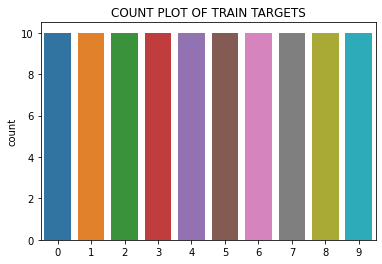

In [14]:
# Creation of train & test dataloaders


trainsetVGG = CIFAR10(root='./data', train=True,download=True, transform=transformVGG,N=100)
trainloaderVGG = torch.utils.data.DataLoader(trainsetVGG, batch_size=10,shuffle=True, num_workers=2)

testsetVGG = CIFAR10(root='./data', train=False,download=True, transform=transformVGG)
testloaderVGG = torch.utils.data.DataLoader(testsetVGG, batch_size=10,shuffle=False, num_workers=2)

In [15]:
# Freeze VGG layers
for param in vgg16.parameters():
    param.requires_grad = False

In [16]:
# Add classifiers layers to pretrained VGG

cifar_classifer = nn.Sequential(
                      nn.Linear(1000, 512), 
                      nn.ReLU(), 
                      nn.Dropout(p=0.5),
                      nn.Linear(512, 10),                   
                      nn.LogSoftmax(dim=1))

vgg16.classifier.add_module("CIFAR_CLASSIFIER",cifar_classifer)
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
  (CIFAR_CLASSIFIER): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [19]:
# Train the model

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters())

for epoch in range(0, 30):
    train(epoch,vgg16.to(device),trainloaderVGG,criterion,optimizer)


Epoch: 0
LOSS 0.5742019519209862
ACCURACY 0.83

Epoch: 1
LOSS 0.4208660326898098
ACCURACY 0.84

Epoch: 2
LOSS 0.6524800479412078
ACCURACY 0.77

Epoch: 3
LOSS 0.4415583048015833
ACCURACY 0.85

Epoch: 4
LOSS 0.3706931222230196
ACCURACY 0.83

Epoch: 5
LOSS 0.3129796914756298
ACCURACY 0.86

Epoch: 6
LOSS 0.3307510569691658
ACCURACY 0.86

Epoch: 7
LOSS 0.3332143886014819
ACCURACY 0.88

Epoch: 8
LOSS 0.22932251691818237
ACCURACY 0.9

Epoch: 9
LOSS 0.25456527546048163
ACCURACY 0.89

Epoch: 10
LOSS 0.33870990835130216
ACCURACY 0.89

Epoch: 11
LOSS 0.29527054000645875
ACCURACY 0.93

Epoch: 12
LOSS 0.5132841385900975
ACCURACY 0.8

Epoch: 13
LOSS 0.2607988975942135
ACCURACY 0.9

Epoch: 14
LOSS 0.4557462275028229
ACCURACY 0.82

Epoch: 15
LOSS 0.31053285785019397
ACCURACY 0.91

Epoch: 16
LOSS 0.3245484080165625
ACCURACY 0.91

Epoch: 17
LOSS 0.2892642289400101
ACCURACY 0.91

Epoch: 18
LOSS 0.28602497968822715
ACCURACY 0.88

Epoch: 19
LOSS 0.26392275262624026
ACCURACY 0.94

Epoch: 20
LOSS 0.35418217

In [20]:
# Test the model
test(vgg16.to(device),testloaderVGG,criterion)

LOSS 1.590111572727561
ACCURACY 0.6027


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   VGG16  | 20 | 0.92 | 0.596 |
|   VGG16  | 30 | 0.92 | 0.60 |

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points):__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

In the case of 32x32 images the resolution is so low that we rapidly encounter boundary effect. 

One way to preserve information while doing augmentation could be to use a padding strategy so that the translation rotation and scale could properly be applied near the border of the image. 

One another way could be to apply transformation to random crop of the upsample image

I chose to implement a reflection padding. 

## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [22]:
# Definition of data augmentations
augmentation_train_transforms =  transforms.Compose([
        #transforms.Resize(64),
        transforms.Pad(5,padding_mode="reflect"),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=5,translate=(0.2,0.2),scale=(0.8,1.2)),
        #transforms.ColorJitter(),
        #transforms.RandomCrop(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  ,
    ])

Files already downloaded and verified
ORIGINAL SHAPE OF DATASET
IMG (50000, 32, 32, 3)
TARGET 50000
NEW SHAPE OF DATASET
IMG (100, 32, 32, 3)
TARGET 100


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


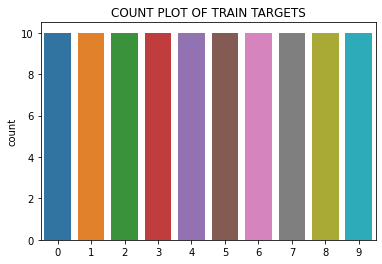

In [23]:
# Creation of augmented train dataset

trainset_augmented = CIFAR10(root='./data', train=True,download=True, transform=augmentation_train_transforms,N=100)
trainloader_augmented = torch.utils.data.DataLoader(trainset_augmented, batch_size=10,shuffle=True, num_workers=2)

In [31]:
# Model initialisation
ResNet18_ = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ResNet18_.parameters())

In [32]:
# Train the model
for epoch in range(0, 50):
    train(epoch,ResNet18_,trainloader_augmented, criterion,optimizer)


Epoch: 0
LOSS 2.917949652671814
ACCURACY 0.11

Epoch: 1
LOSS 2.3292946219444275
ACCURACY 0.15

Epoch: 2
LOSS 2.276394283771515
ACCURACY 0.15

Epoch: 3
LOSS 2.317522978782654
ACCURACY 0.13

Epoch: 4
LOSS 2.0254823565483093
ACCURACY 0.21

Epoch: 5
LOSS 2.0158523082733155
ACCURACY 0.22

Epoch: 6
LOSS 1.9580332279205321
ACCURACY 0.24

Epoch: 7
LOSS 2.055585479736328
ACCURACY 0.24

Epoch: 8
LOSS 1.923242175579071
ACCURACY 0.26

Epoch: 9
LOSS 1.921143889427185
ACCURACY 0.33

Epoch: 10
LOSS 1.8502428531646729
ACCURACY 0.33

Epoch: 11
LOSS 1.9044936656951905
ACCURACY 0.28

Epoch: 12
LOSS 1.9283490538597108
ACCURACY 0.3

Epoch: 13
LOSS 1.8260382056236266
ACCURACY 0.3

Epoch: 14
LOSS 1.9676867365837096
ACCURACY 0.3

Epoch: 15
LOSS 1.7160832166671753
ACCURACY 0.39

Epoch: 16
LOSS 1.7540851354598999
ACCURACY 0.38

Epoch: 17
LOSS 1.8413870811462403
ACCURACY 0.29

Epoch: 18
LOSS 1.867654848098755
ACCURACY 0.32

Epoch: 19
LOSS 1.6285925149917602
ACCURACY 0.46

Epoch: 20
LOSS 1.5822775840759278
ACCUR

In [34]:
# Test the model

test(ResNet18_.to(device),testloader,criterion)

LOSS 3.7528221527338026
ACCURACY 0.2292


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   RESNET18  | 30 | 0.53 | 0.22 |
|   RESNET18  | 50 | 0.57 | 0.23 |

# Conclusions

__Question 7 (5 points):__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

__Response 7:__

1) Vanilla Resnet Architecture

This method is easy to implement but provides poor results. The accuracy accuracy barely exceeds 20%. Because of the lack of data the model quickly overfit and thus it makes no sense to add more epochs. We are limited by the available amount of data. This method would be suitable if we use X instead of Xtrain. 

2) Pretrained Resnet 

Fine tuning a pre trained model is really powerful. We avoid the learning of the feature extraction part and only train a classifier on our own dataset using the already learnt feature. With more computational power we could have retrained some deeper block of the VGG model to get better results. Nonetheless we can already notice improvement on the results compared with the vanilla architecture. This method helps the model to converge faster, this is useful in our case as we don’t have much data. However this method implies that the pretraining is somewhat related with our current task which is here reasonable to assume.

3) Data augmentation 

Data augmentation can be easily done on the fly  with pytorch  with the data loader object. It helps increase artificially the number of samples in the dataset. However geometric augmentation is not always meaningful especially in small images like CIFAR10 ones. The results might be noisy and mislead the model. When designing the transformation one has to be aware of the resulting images. If a transformation results in a nonsense sample ( such as a blue cat upside down with a height scale by 30 and a width scale by 0.01) the augmented data will be of no help and will mislead the model. Nonetheless when done properly data augmentation has proven to provide better results and give more generalisation power to the model. However in our case, I have not found any data augmentation that could lead to significantly better results.
